In [3]:
import sys
if 'ipykernel_launcher.py' in sys.argv[0]:
    print("Launched in Jupyter")
    %load_ext autoreload
    %autoreload 2

import torch.onnx
import torch
import numpy as np
import powderworld.gen
from powderworld import PWSim, PWRenderer

device = 'cuda'
world = torch.zeros((1, 64, 128, 9), dtype=torch.float32, device=device)

class PwTranspose(torch.nn.Module):
    def __init__(self, device):
        super().__init__()
        self.pw = PWSim(device, use_jit=False)
    def forward(self, x):
        x = x.permute(0,3,1,2)
        x = self.pw(x)
        return x.permute(0,2,3,1)
    
class PwrTranspose(torch.nn.Module):
    def __init__(self, device):
        super().__init__()
        self.pwr = PWRenderer(device)
    def forward(self, x):
        x = x.permute(0,3,1,2)
        x = self.pwr(x)
        x = x.permute(1,2,0) # 64 x 64 x 3
        x = torch.cat([x, torch.ones((64,128,1)).to(device)], dim=2)
        x = (x*255).int()
        return x
    
    
pw = PwTranspose(device)
pwr = PwrTranspose(device)

torch.onnx.export(pw,               # model being run
                  world,                         # model input (or a tuple for multiple inputs)
                  "pw.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=11,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

torch.onnx.export(pwr,               # model being run
                  world,                         # model input (or a tuple for multiple inputs)
                  "pwr.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=11,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})


Launched in Jupyter
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/data/vision/phillipi/powderworld/envs/frog2/lib/python3.9/site-packages/torch/onnx/_internal/jit_utils.py:258: UserWarning: The shape inference of prim::Constant type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642975993/work/torch/csrc/jit/passes/onnx/shape_type_inference.cpp:1884.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/data/vision/phillipi/powderworld/envs/frog2/lib/python3.9/site-packages/torch/onnx/utils.py:687: UserWarning: The shape inference of prim::Constant type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642975993/work/torch/csrc/jit/passes/onnx/shape_type_inference.cpp:1884.)
  _C._jit_pass_onnx_graph_shape_type_inference(
/data/vision/phillipi/powderworld/

In [4]:
from IPython import display as ipythondisplay
import matplotlib.pyplot as plt
def show_row(imgs, name='dist', size=4):
    fig = plt.figure(figsize=(16*size,16))
    axarr = fig.subplots(1, size)
    for b in range(size):
        axarr[b].imshow(imgs[b])
        axarr[b].get_xaxis().set_visible(False)
        axarr[b].get_yaxis().set_visible(False)
    del imgs
    fig.show()
    # fig.savefig('figs/{}.png'.format(name))
    plt.show()
    del fig

2023-04-30 23:16:17.890737077 [W:onnxruntime:, session_state.cc:1030 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2023-04-30 23:16:17.890880906 [W:onnxruntime:, session_state.cc:1032 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


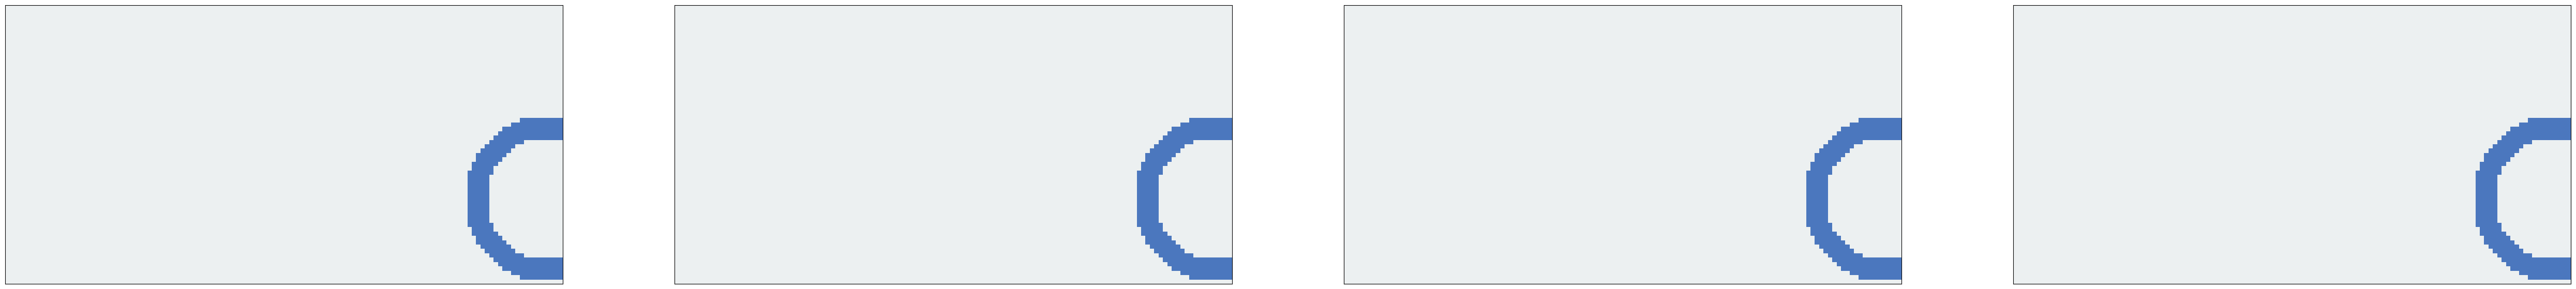

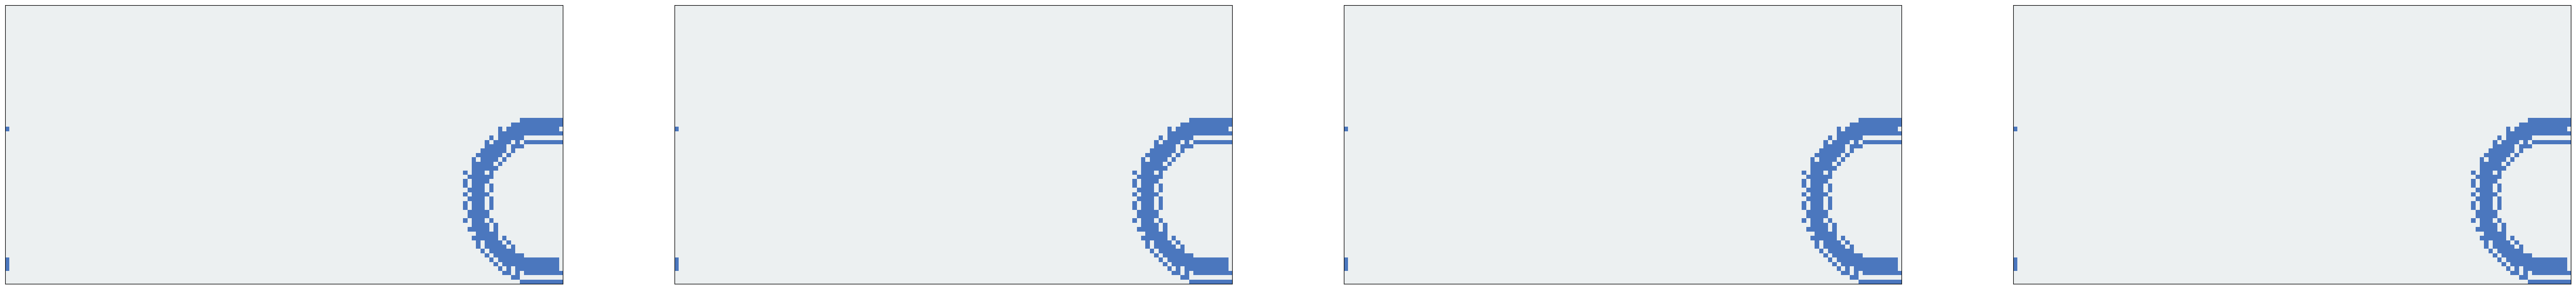

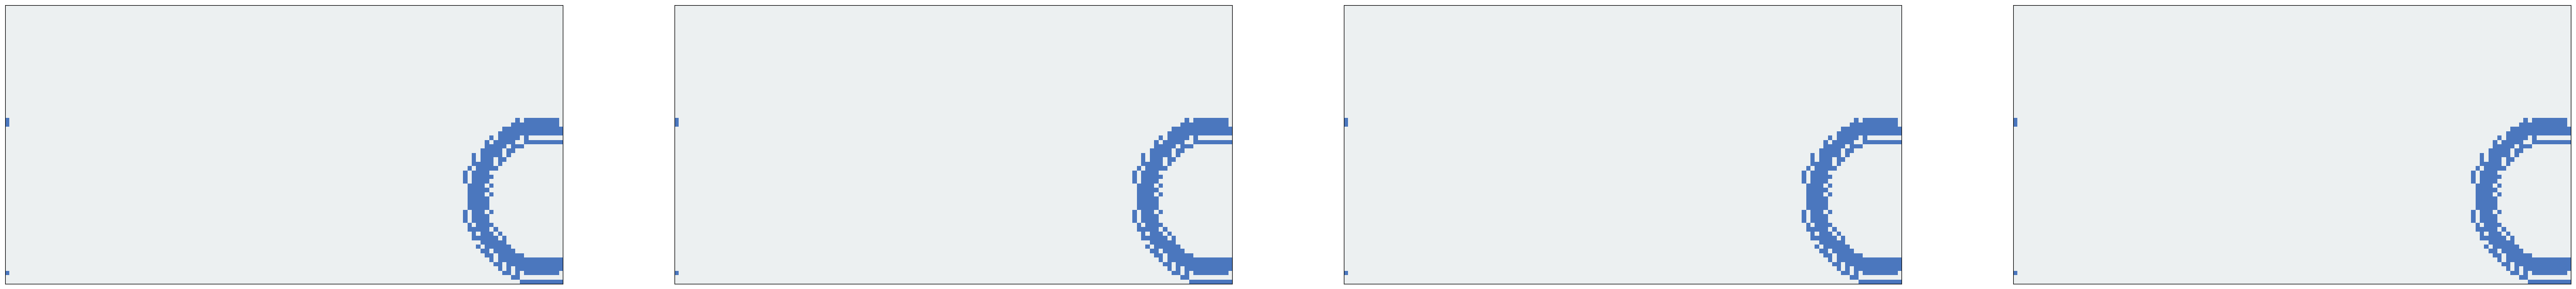

AssertionError: 
Not equal to tolerance rtol=0.001, atol=1e-05

Mismatched elements: 611 / 294912 (0.207%)
Max absolute difference: 3.
Max relative difference: 1.
 x: array([[[[0., 1., 1., ..., 0., 0., 0.],
         [0., 1., 1., ..., 0., 0., 0.],
         [0., 1., 1., ..., 0., 0., 0.],...
 y: array([[[[ 0.,  1.,  1., ...,  0.,  0.,  0.],
         [ 0.,  1.,  1., ...,  0.,  0.,  0.],
         [ 0.,  1.,  1., ...,  0.,  0.,  0.],...

In [5]:
import onnxruntime

onnx_pw = onnxruntime.InferenceSession("pw.onnx", providers=['CUDAExecutionProvider'])
onnx_pwr = onnxruntime.InferenceSession("pwr.onnx", providers=['CUDAExecutionProvider'])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

np_world = np.zeros((4, 64, 128), dtype=np.uint8)
for b in range(4):
    np_world[b:b+1] = powderworld.gen.init_world(64, 128)
    powderworld.gen.do_circle(np_world[b:b+1], np.random, 'water')

world = pw.pw.np_to_pw(np_world)
world = world.permute(0,2,3,1)

# Torch
world2_torch = pw(torch.clone(world))
render_torch = pwr(world2_torch)

# Onnx
world2_onnx = onnx_pw.run(None, {'input': to_numpy(world)})[0]
render_onnx = onnx_pwr.run(None, {'input': world2_onnx})[0]

show_row([pwr(world).cpu().numpy() for m in range(4)])
show_row([render_torch.cpu().numpy() for m in range(4)])
show_row([render_onnx for m in range(4)])

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(world2_torch), world2_onnx, rtol=1e-03, atol=1e-05)
np.testing.assert_allclose(to_numpy(render_torch), render_onnx, rtol=1e-03, atol=1e-05)